In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import re
from datetime import datetime as dt
from tqdm import tqdm
import scipy.stats as ss
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import recall_score, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

%matplotlib inline

# Extract

In [2]:
key = '69d03443c6dda74d5729a2be5debd168'

In [3]:
tmdb_api_url = 'https://api.themoviedb.org/3/'

def get_genres(api_key=key):
    api_key = f'api_key={api_key}'
    tmdb_api_url = 'https://api.themoviedb.org/3/'
    
    get_genres = 'genre/movie/list'
    response = requests.get(tmdb_api_url + '?'.join([get_genres, api_key]))
    genres = response.json()['genres']
    
    genres_ls = [d['name'] for d in genres]
    genres_ls.append('Foreign')
    genres_ls = sorted(genres_ls)
    n_genres = len(genres_ls)
    
    return {'n_genres': n_genres, 'genres_ls': genres_ls}

def get_details_and_reviews(api_key=key, goodness_thresh=80, **kwargs):
    api_key = f'api_key={api_key}'
    n_genres = kwargs['n_genres']
    genrs_
    
    tmdb = pd.read_csv('data/tmdb_5000_movies.csv')

    tmdb['goodness'] = tmdb['vote_average'] * tmdb['vote_count'] / tmdb['vote_count'].max()
    # threshold -> 80th percentile (default)
    threshold = np.around(np.percentile(tmdb['goodness'], goodness_thresh), 2)
    # encoding 1 <-> goodness >= threshold
    tmdb['goodness_enc'] = 0
    tmdb.loc[tmdb['goodness'] >= threshold, 'goodness_enc'] = 1
    
    cols_to_keep = ['id', 'title', 'status', 'release_date', 'budget', 'revenue',
                    'original_language', 'runtime', 'popularity', 'goodness_enc']
    # keeping only movies that have a positive vote_count
    tmdb_clean = tmdb.loc[tmdb['vote_count'] > 0, cols_to_keep].dropna(axis=0).reset_index(drop=True)
    
    reviews = pd.Series(name='reviews')
    df_genres = pd.DataFrame(columns=genres_ls)
    
    for i, movie_id in enumerate(tqdm(tmdb_clean['id'])):
        get_reviews = f'movie/{movie_id}/reviews'
        response_reviews = requests.get(tmdb_api_url + '?'.join([get_reviews, api_key]))
        if response_reviews.status_code == 200:
            reviews.loc[i] = [d['content'] for d in response_reviews.json()['results']]
        else:
            reviews.loc[i] = []

        df_genres.loc[i] = np.zeros(n_genres, dtype=int)
        movie_genres = re.findall(r'\"name\": \"([A-Za-z\s]+)\"', tmdb['genres'][i])
        df_genres.loc[i, movie_genres] = 1
        
    df = pd.concat([tmdb_clean, df_genres, reviews], axis=1).sort_values('id').reset_index(drop=True)

    # turning dtype of release_date to datetime and extracting only the year
    df['release_date'] = pd.to_datetime(df['release_date'], infer_datetime_format=True).dt.year
    df = df.rename(columns={'release_date': 'release_year'})

    # keeping only movies that have been released
    df = df[df['status'] == 'Released'].reset_index(drop=True)
    details = df.drop(['status', 'reviews', 'Foreign', 'TV Movie'], axis=1)
    details.to_csv('data/details.csv', index=False)
    
    reviews = df[['id', 'title', 'reviews', 'goodness_enc']]
    reviews.to_csv('data/reviews.csv', index=False)

# Load and Clean

In [4]:
def clean_details(df):
    # binning low count languages (<10) in category called 'other'
    lang_counts = df['original_language'].value_counts()
    df.loc[df['original_language'].isin(lang_counts[lang_counts < 10].index), 'original_language'] = 'other'
    
    # dropping features that are irrelevant for prediction
    df.drop(['id', 'title'], axis=1, inplace=True)
    
    return df

# def clean_reviews(df):
#     return df

def get_data(csv_file, target='goodness_enc'):
    df = pd.read_csv(f'data/{csv_file}.csv')
    
    df_clean = clean_details(df)
    X = df_clean.drop(target, axis=1)
    X = pd.get_dummies(X, drop_first=True)
    y = df_clean[target]
    
    return {'X': X, 'y': y}

# Transform

In [5]:
def split_func(test_size=.2, **kwargs):
    X = kwargs['X']
    y = kwargs['y']
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=test_size,
                                                        stratify=y)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split_func(**get_data(csv_file='details'))

# Models

## Logistic Regression

In [7]:
logr_clf = LogisticRegression(max_iter=20000,
                              tol=.001
                              random_state=42,
                              n_jobs=-1)

logr_params = {'logr__penalty': ['l1', 'l2', 'elasticnet'],
               'logr__C': ss.uniform(0, 100),
               'logr__l1_ratio': ss.uniform(0, 1)}

## k Nearest Neighbors  (kNN)

In [8]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

knn_params = {'knn__n_neighbors': range(1,100,2),
              'knn__weights': ['uniform', 'distance']}

## Support Vector Machine (SVM)

In [9]:
svm_clf = SVC(max_iter=20000,
              tol=.01
              random_state=42)

svm_params = {'svm__C': ss.uniform(0, 100),
              'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'svm__degree': [1, 2, 3],
              'svm__coef0': ss.uniform(0, 10)}

## Random Forest (RF)

In [10]:
rf_clf = RandomForestClassifier(n_jobs=-1,
                                random_state=42)

rf_params = {'rf__n_estimators': range(1,500),
             'rf__criterion': ['gini', 'entropy'],
             'rf__max_depth': [1, 2, 3, 4],
             'rf__max_features': range(1, X_train.shape[1]),
             'rf__max_samples': range(1, X_train.shape[0])}

## Light Gradient Boosting Machine (LGBM)

In [11]:
lgbm_clf = LGBMClassifier(random_state=42,
                          n_jobs=-1)

lgbm_params = {'lgbm__boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
               'lgbm__max_depth': [1, 2, 3, 4],
               'lgbm__learning_rate': ss.uniform(0, 1),
               'lgbm__n_estimators': range(1,500),
               'lgbm__subsample': ss.uniform(0.001, 1),
               'lgbm__subsample_freq': range(1,101),
               'lgbm__colsample_bytree': ss.uniform(0.001, 1),
               'lgbm__reg_alpha': ss.uniform(0, 1),
               'lgbm__reg_lambda': ss.uniform(0, 1)}

## Extreme Gradient Boosting (XGBoost)

In [12]:
xgb_clf = XGBClassifier(max_iter=10000,
                        random_state=42)

xgb_params = {'xgb__max_depth': [1, 2, 3, 4],
              'xgb__learning_rate': ss.uniform(0, 1),
              'xgb__boster': ['gbtree', 'gblinear', 'dart'],
              'xgb__subsample': ss.uniform(0.001, 1),
              'xgb__colsample_bytree': ss.uniform(0.001, 1),
              'xgb__colsample_bylevel': ss.uniform(0.001, 1),
              'xgb__colsample_bynode': ss.uniform(0.001, 1),
              'xgb__reg_alpha': ss.uniform(0, 1),
              'xgb__reg_lambda': ss.uniform(0, 1),
              'xgb__num_parallel_tree': range(1,500)}

## Multilayer Perceptron (MLP)

In [13]:
mlp_clf = MLPClassifier(max_iter=10000,
                        early_stopping=True,
                        random_state=42)

mlp_params = {'mlp__hidden_layer_sizes': range(1,500),
              'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
              'mlp__solver': ['lbfgs', 'sgd', 'adam'],
              'mlp__alpha': ss.uniform(0, 1),
              'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
              'mlp__learning_rate_init': ss.uniform(0, 1),
              'mlp__momentum': ss.uniform(0, 1),
              'mlp__beta_1': ss.uniform(0, 0.999),
              'mlp__beta_2': ss.uniform(0, 0.999)}

# Pipeline

In [14]:
models = {'logr': [logr_clf, logr_params],
          'knn': [knn_clf, knn_params],
          'svm': [svm_clf, svm_params],
          'rf': [rf_clf, rf_params],
          'lgbm': [lgbm_clf, lgbm_params],
          'xgb': [xgb_clf, xgb_params],
          'mlp': [mlp_clf, mlp_params]}

In [15]:
best_estimators = {}
for m in tqdm(models.keys()):
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                         (m, models[m][0])])

    rscv = RandomizedSearchCV(pipeline,
                              models[m][1],
                              scoring='recall',
                              n_jobs=-1,
                              cv=3,
                              n_iter=100,
                              verbose=True)

    rscv.fit(X_train, y_train)
    
    best_estimators[m] = rscv.best_estimator_

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
 14%|█▍        | 1/7 [02:08<12:50, 128.36s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished
 29%|██▊       | 2/7 [06:53<14:36, 175.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 43%|████▎     | 3/7 [09:53<11:47, 176.92s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   42.2s finished
 57%|█████▋    | 4/7 [10:37<06:50, 136.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/jeffc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
 71%|███████▏  | 5/7 [11:45<03:52, 116.17s/it]

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/jeffc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 55.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 87.9min finished
 86%|████████▌ | 6/7 [1:40:03<27:50, 1670.92s/it]

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/jeffc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.0min finished
100%|██████████| 7/7 [2:27:21<00:00, 1263.14s/it]


## Stacking

In [16]:
sub_pipeline = Pipeline([('scaler', StandardScaler()),
                         ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                         ('mlp', best_estimators['mlp'])])

estimators = [('logr', best_estimators['logr']),
              ('knn', best_estimators['knn']),
              ('svm', best_estimators['svm']),
              ('rf', best_estimators['rf']),
              ('lgbm', best_estimators['lgbm']),
              ('xgb', best_estimators['xgb']),
              ('pipe', sub_pipeline)]

blender = StackingClassifier(estimators, cv=3, n_jobs=-1)
blender.fit(X_train, y_train)

best_estimators['stack'] = blender

/home/jeffc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


# Evaluation

## Recall Scores (threshold = 0.5)

In [24]:
recall_scores = {}
recall_scores['train recall'] = []
recall_scores['test recall'] = []
for m in best_estimators.keys():
    best = best_estimators[m]
    y_train_pred = best.predict(X_train)
    y_test_pred = best.predict(X_test)
    recall_scores['train recall'].append(round(100 * cross_val_score(best,
                                                               X_train,
                                                               y_train,
                                                               cv=3,
                                                               scoring='recall',
                                                               n_jobs=-1).mean(), 4))
    recall_scores['test recall'].append(round(100 * recall_score(y_test, y_test_pred), 4))

recall_scores_df = pd.DataFrame(recall_scores, index=list(best_estimators.keys()))
recall_scores_df

,train recall,test recall
logr,77.5786,76.5625
knn,55.2814,52.0833
svm,80.5780,77.6042
rf,84.2274,81.2500
lgbm,93.7383,89.0625
xgb,85.2701,80.7292
mlp,77.7083,76.0417
stack,NaN,83.3333


## Learning Curves

/home/jeffc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/jeffc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11)}

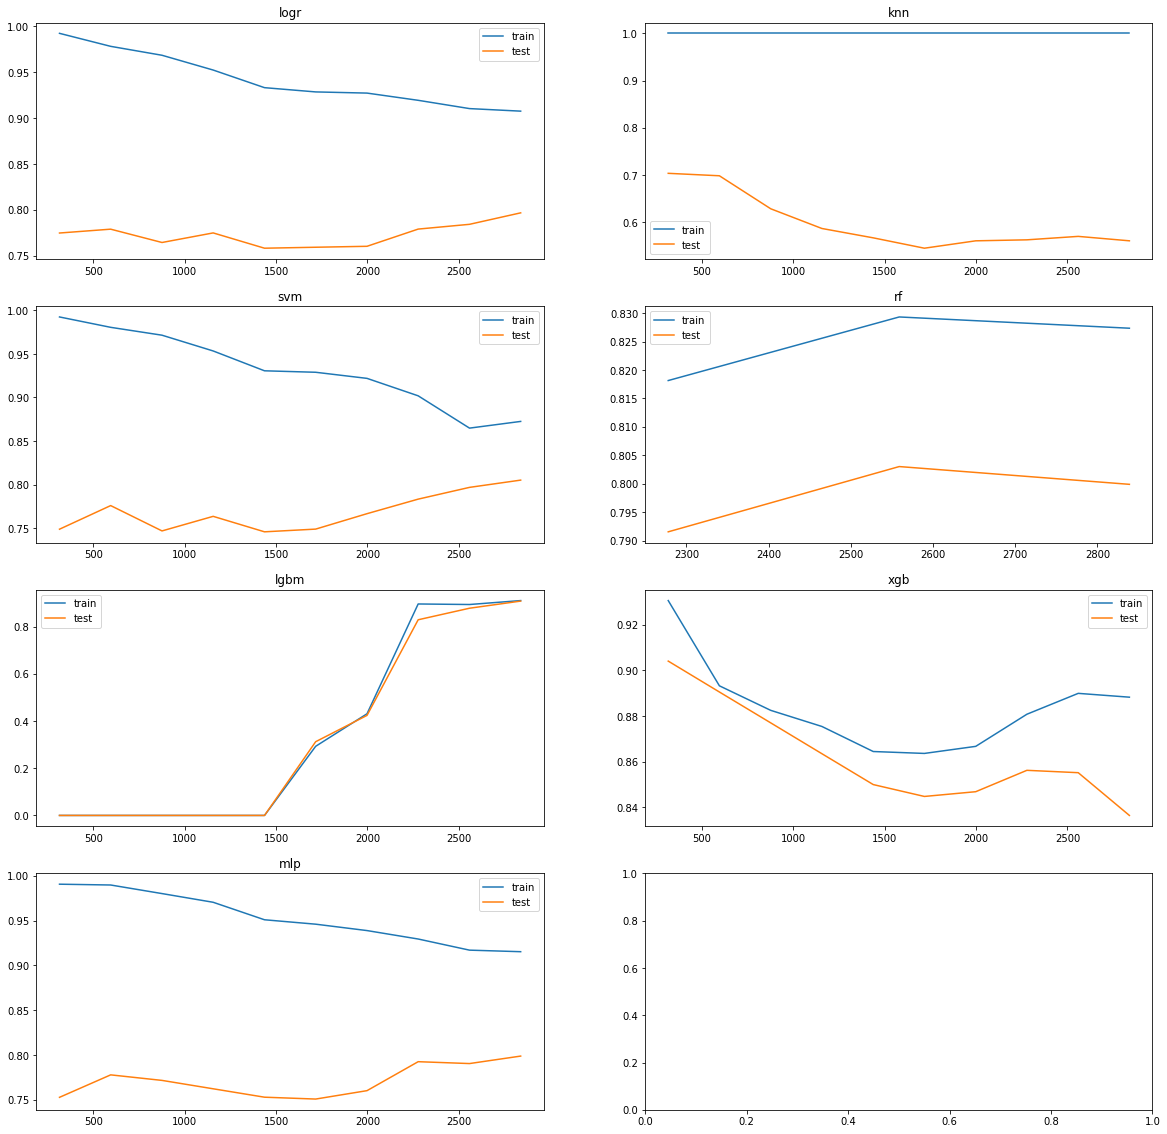

In [21]:
X = get_data('details')['X']
y = get_data('details')['y']

fig, ax = plt.subplots(4, 2, figsize=(20,20))
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1],
        ax[2,0], ax[2,1], ax[3,0], ax[3,1]]

for i, m in enumerate(best_estimators.keys()):
    train_sizes, train_scores, test_scores = learning_curve(best_estimators[m],
                                                            X,
                                                            y,
                                                            train_sizes=np.linspace(0.1, 0.9, 10),
                                                            cv=3,
                                                            scoring='recall',
                                                            n_jobs=-1)
    
    sns.lineplot(train_sizes, train_scores.mean(axis=1), markers=True, ax=axes[i]).set_title(m)
    sns.lineplot(train_sizes, test_scores.mean(axis=1), markers=True, ax=axes[i])
    axes[i].legend(['train', 'test']);

## Precision-Recall Curves

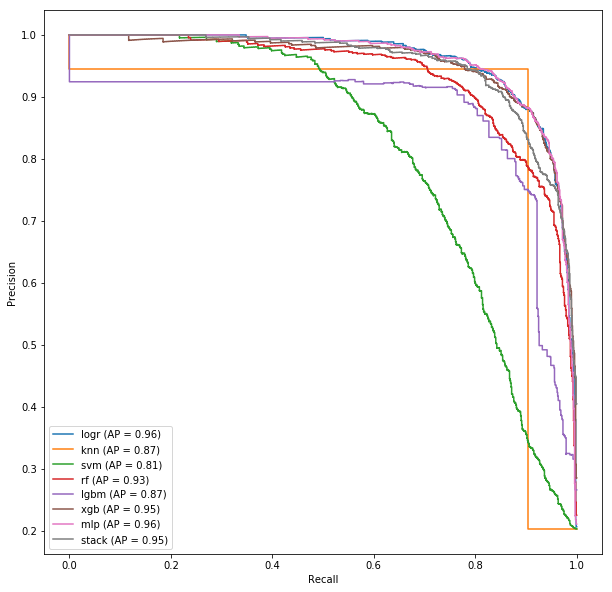

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
for m in best_estimators.keys():
    plot_precision_recall_curve(best_estimators[m], X, y, name=m, ax=ax)